In [1]:
import matplotlib.pyplot as plt
import torch
import os
import logging
import scanpy as sc
import random
import numpy as np
import scvi as scvi

Global seed set to 0


In [2]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)

In [4]:
# Make analysis reproducible... at least on some nodes

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=0
set_seed(seed)

Global seed set to 0


In [6]:
adata = sc.read_h5ad(
    "../output/H5AD/mergedH.h5ad")


In [7]:
adata

AnnData object with n_obs × n_vars = 60247 × 39606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'cellName', 'line', 'chemistry', 'stage', 'sort'
    var: 'features'

In [8]:
adata.obs["orig.ident"].unique()

array(['GOL-2512A5', 'GOL2976A5', 'Sample_32', 'Sample_33', 'Sample_34',
       'Sample_C27_CD140_3', 'Sample_C27_DAPI_3', 'Sample_C27_Shi',
       'Sample_C27_undiff_1', 'Sample_CD-140', 'Sample_CD140_WA09_5',
       'Sample_unsorted', 'Sample_Unsorted_WA09_5', 'Sample_WA09_Shiv',
       'Sample_WA09_undiff_1'], dtype=object)

In [9]:
#Subset to In Vivo only
target_conditions = ['Sample_32', 'Sample_33', 'Sample_34', 'Sample_WA09_Shiv', "Sample_C27_Shi", "GOL-2512A5", "GOL2976A5"]

In [10]:
adata = adata[adata.obs['orig.ident'].isin(target_conditions)].copy()

In [11]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [12]:
#Determine variable genes between line and chemistry
adata.obs["concat"] = adata.obs["line"] + adata.obs["chemistry"]

In [13]:
adata.obs["concat"].unique()

array(['C27v3.1', 'WA09v2', 'C27v2'], dtype=object)

In [14]:
### Currently used 3000
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="concat",
    span = .5, 
)

In [15]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["chemistry", "line", "orig.ident"],
    continuous_covariate_keys=["percent.mt", "nCount_RNA", "nFeature_RNA"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 5337 cells, 3000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 3 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


In [16]:
model = scvi.model.SCVI(adata)

In [17]:
model.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 400/400: 100%|██████████| 400/400 [03:44<00:00,  1.78it/s, loss=1.47e+03, v_num=1]


In [18]:
model.save("../output/scVI/Invivo_Model_SCVI")

In [19]:
model = scvi.model.SCVI.load("../output/scVI/Invivo_Model_SCVI", adata)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 5337 cells, 3000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 3 extra
         continuous covariates.                                                              


/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [20]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [21]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [22]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [23]:
# 30.  Seed = 0
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 30, random_state=seed)


In [24]:
# min_dist = .6
sc.tl.umap(adata, min_dist = .3, random_state=seed)

/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'line' as categorical
/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecat

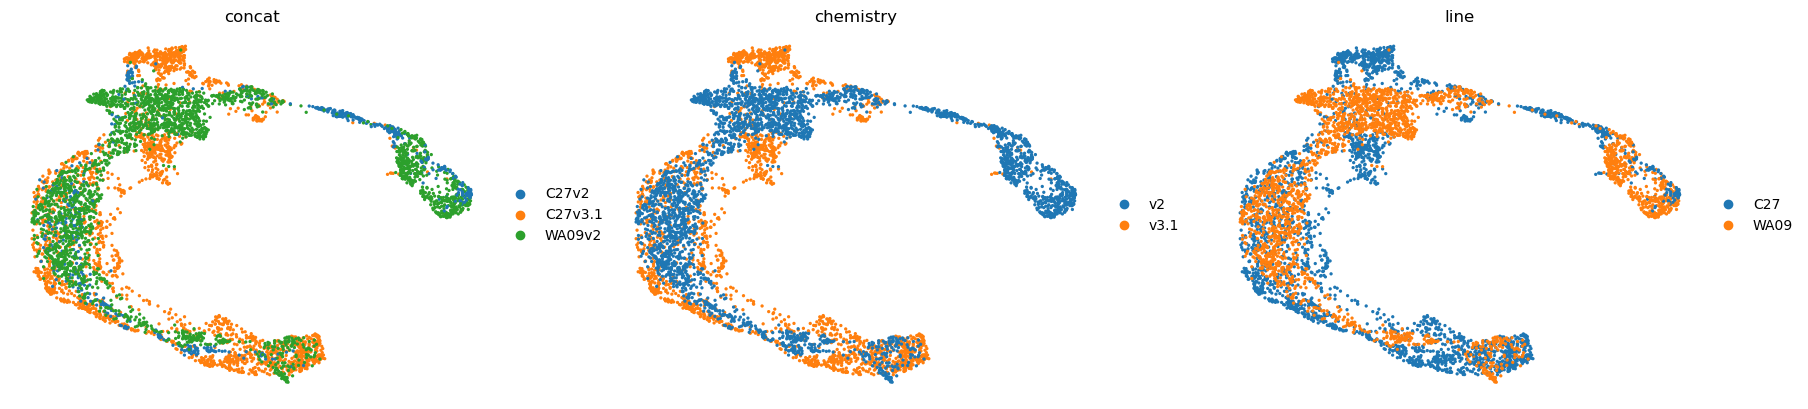

In [25]:
#1
sc.pl.umap(
    adata,
    color=["concat", "chemistry", "line"],
    frameon=False
)

In [26]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [27]:
# min_dist = .6
sc.tl.umap(adata, min_dist = .3, random_state=seed)

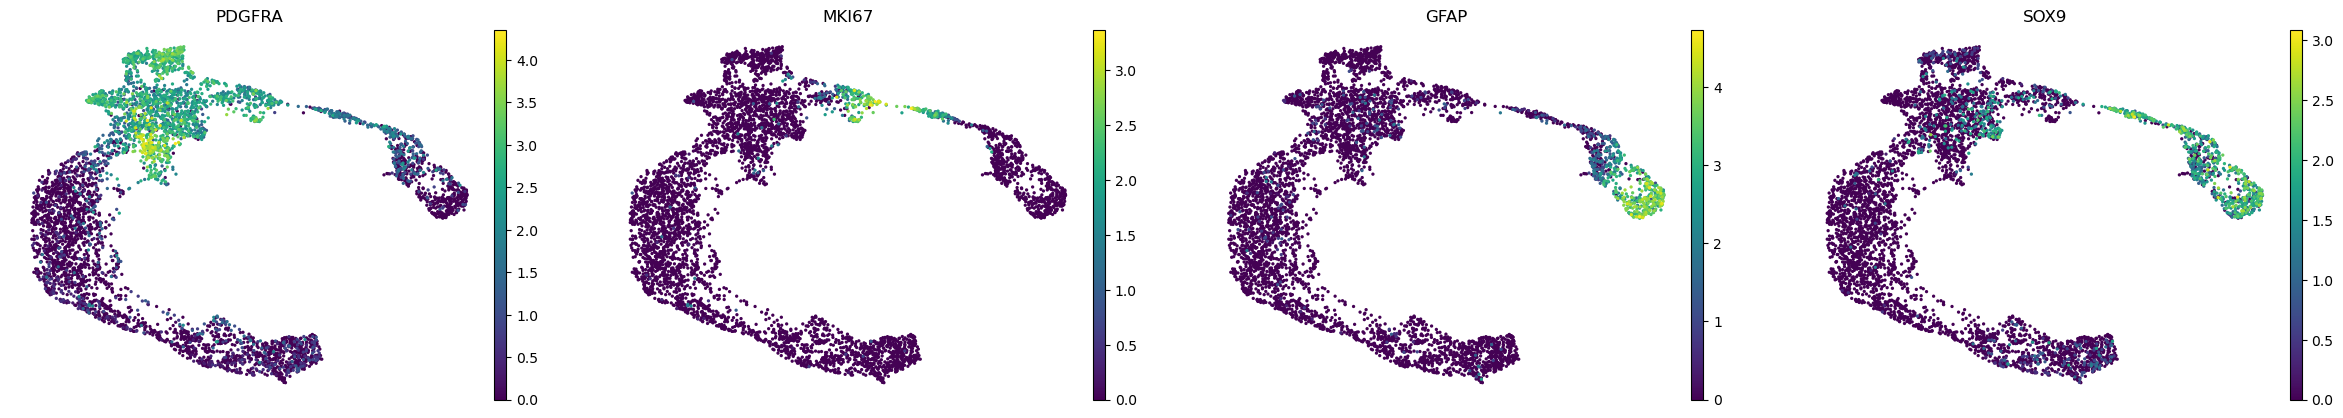

In [28]:
#1
sc.pl.umap(
    adata,
    color=["PDGFRA", "MKI67", "GFAP", "SOX9"],
    frameon=False
)

In [29]:
# .45
sc.tl.leiden(adata, key_added="leiden_scVI", resolution= .45)



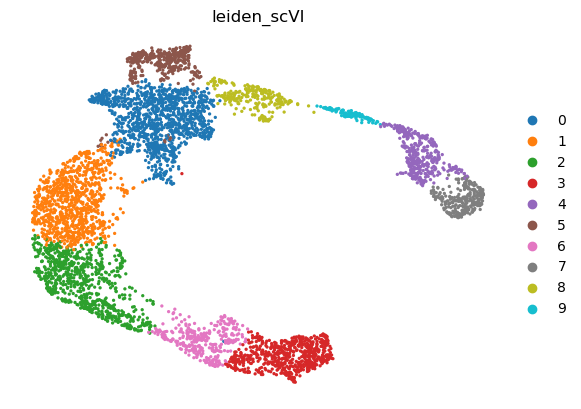

In [30]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False
)

In [31]:
adata.obs["leiden_scVI"].value_counts()

0    1211
1     937
2     780
3     644
4     376
5     373
6     353
7     290
8     261
9     112
Name: leiden_scVI, dtype: int64

In [32]:
adata.write("../output/scVI/Invivo_scvi.h5ad")

In [33]:
umapEmbeddings = adata.obsm["X_umap"]

In [34]:
np.savetxt("../output/scVI/Invivo_umapEmbeddings.csv", umapEmbeddings, delimiter=",")

In [35]:
leiden_clusters = adata.obs["leiden_scVI"]

In [36]:
type(leiden_clusters)

pandas.core.series.Series

In [37]:
adata.obs["leiden_scVI"].to_csv('../output/scVI/Invivo_leiden.csv')


In [38]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.12.1
logging==0.5.1.2
scanpy==1.7.2
numpy==1.21.5
scvi==0.14.5
